# Deep Learning approach - Save the vineyard!

<img src="vineyard.jpeg" width="600" height="700">

<h3><center> Čo nejde silou, pôjde ešte väčšou. (autor neznámy)
</center></h3>


In [14]:
import os
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, Dropout
from keras.models import Sequential, load_model, save_model
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

def read_images(path, downsample=8):
    print('Reading from', path)
    files = [file for file in os.listdir(path) if file.endswith('.JPG')]
    image = imread(path + files[0])
    print('Original resolution:', image.shape)
    new_height = 224 
    new_width = 224
    images = np.zeros(shape=(2*len(files), new_height, new_width, image.shape[2]))
    for i, file in enumerate(files):
        image = imread(path + file)
        # crop picture to make it square
        image = image[:, (image.shape[1]-image.shape[0])//2 : (image.shape[1]+image.shape[0])//2, :]
        # resize
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        images[2*i, :,:,:] = image
        images[2*i+1, :,:,:] = np.fliplr(image)
        
    print('New resolution:', images[0].shape)
    return images.astype(np.uint8)

zdrave = read_images(path='zdrave/')
esca = read_images(path='esca/')
suche = read_images(path='suche/')

Reading from zdrave/
Original resolution: (2160, 3840, 3)
New resolution: (224, 224, 3)
Reading from esca/
Original resolution: (2160, 3840, 3)
New resolution: (224, 224, 3)
Reading from suche/
Original resolution: (2160, 3840, 3)
New resolution: (224, 224, 3)


<IPython.core.display.Javascript object>


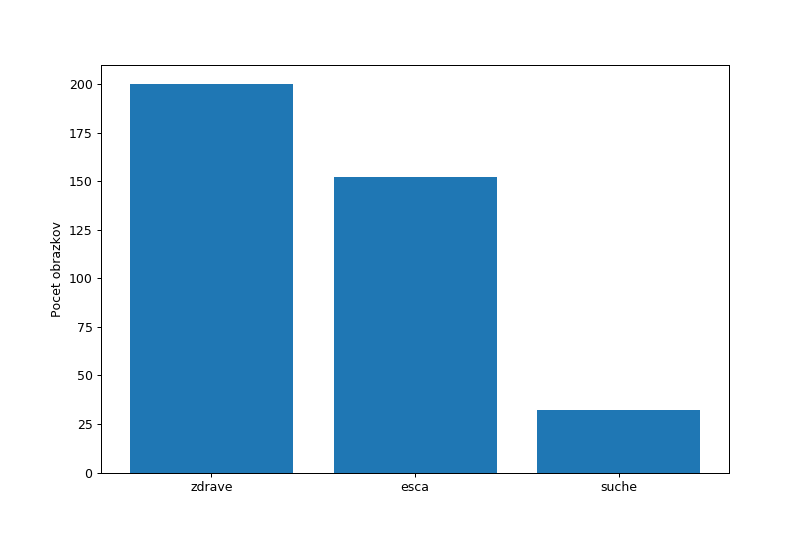

In [23]:
%matplotlib notebook
plt.figure(figsize=(9,6))
plt.bar(['zdrave', 'esca', 'suche'], [zdrave.shape[0], esca.shape[0], suche.shape[0]])
plt.ylabel('Pocet obrazkov')
plt.show()

<IPython.core.display.Javascript object>


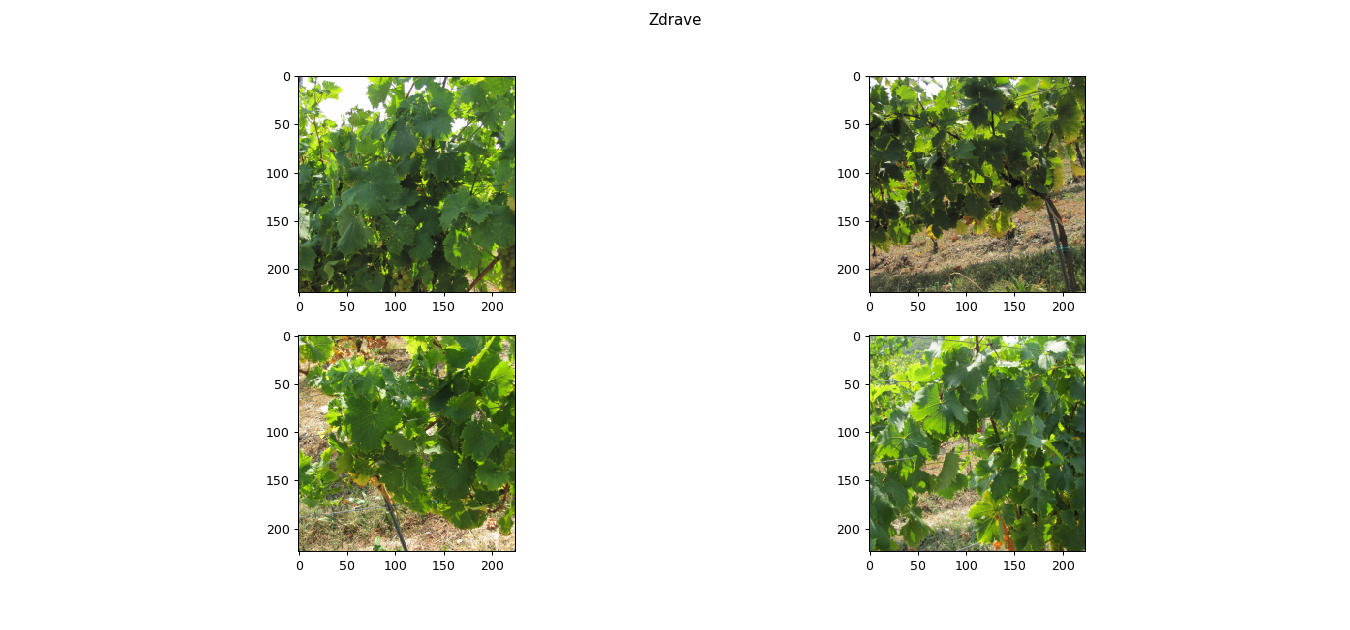

<IPython.core.display.Javascript object>


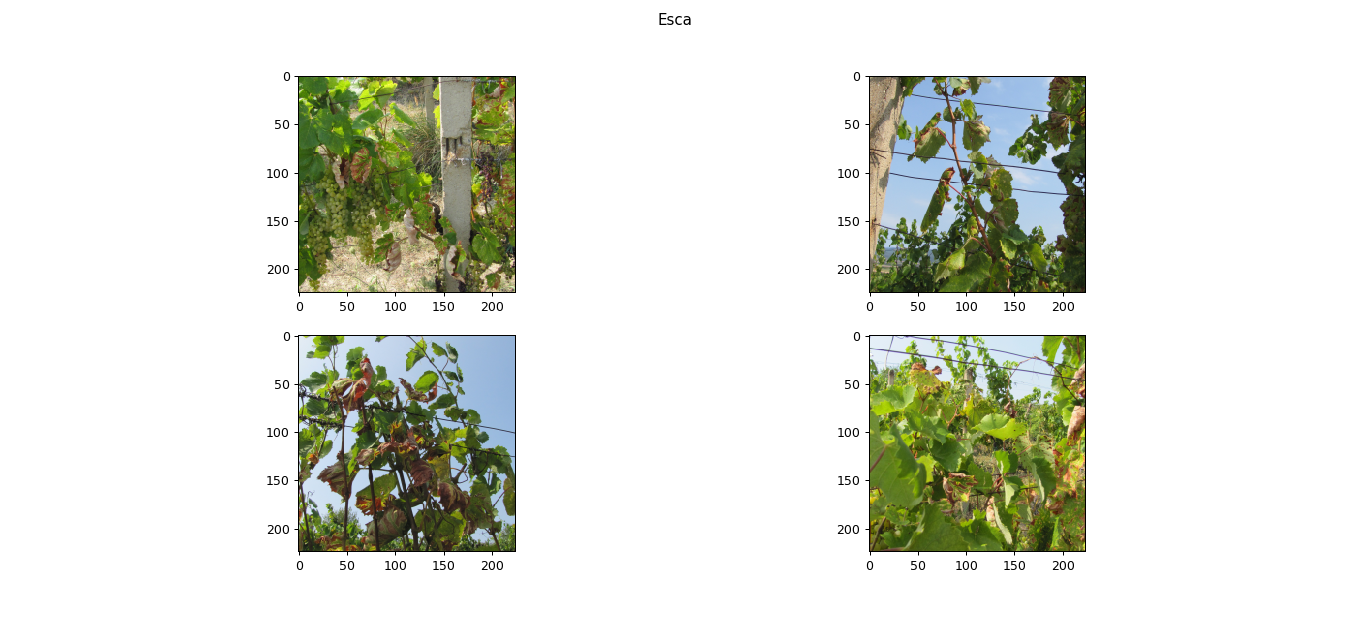

<IPython.core.display.Javascript object>


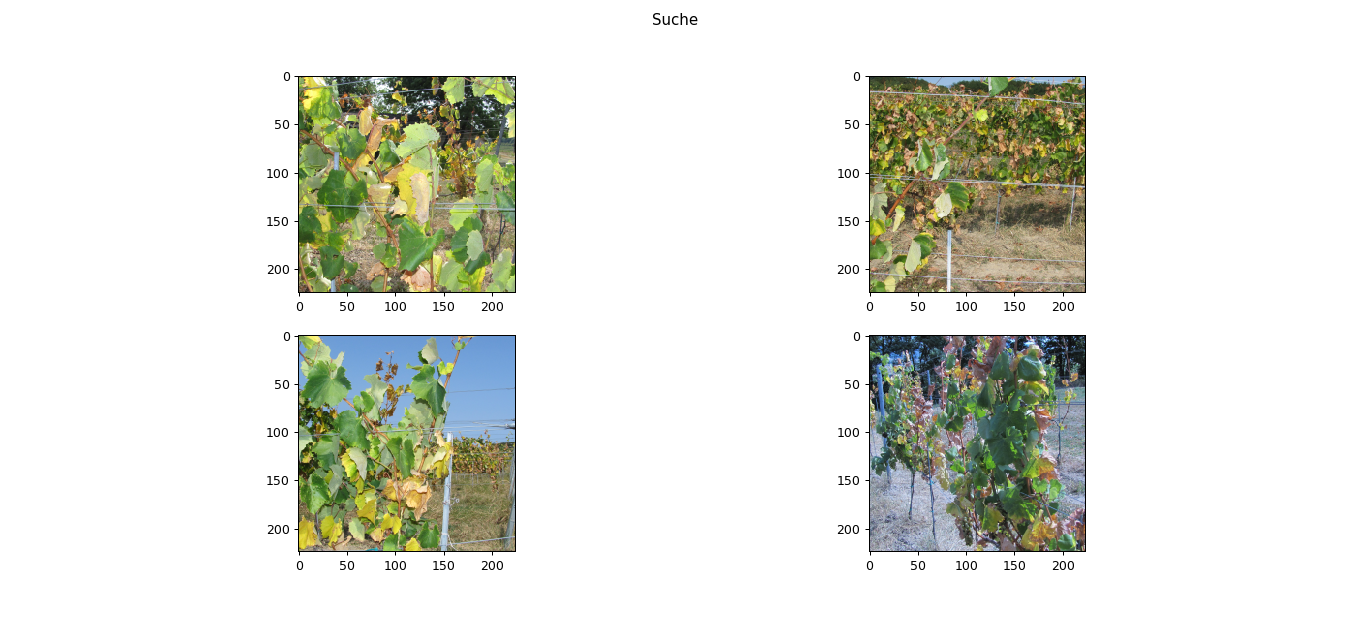

In [24]:
def random_image_sample(img_list, title=''):
    rnd_nbs = np.random.randint(len(img_list), size=4)
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(221)
    plt.imshow(img_list[rnd_nbs[0]])
    fig.add_subplot(222)
    plt.imshow(img_list[rnd_nbs[1]])
    fig.add_subplot(223)
    plt.imshow(img_list[rnd_nbs[2]])
    fig.add_subplot(224)
    plt.imshow(img_list[rnd_nbs[3]])
    plt.suptitle(title)
    plt.show()
    
random_image_sample(zdrave, title='Zdrave')
random_image_sample(esca, title='Esca')
random_image_sample(suche, title='Suche')

In [22]:
train_ratio = 0.7
X_train = np.append(np.append(zdrave[:int(train_ratio * len(zdrave))], \
                              esca[:int(train_ratio * len(esca))], axis=0), \
                   suche[:int(train_ratio * len(suche))], axis=0)

X_test = np.append(np.append(zdrave[int(train_ratio * len(zdrave))::2], \
                             esca[int(train_ratio * len(esca))::2], axis=0), \
                   suche[int(train_ratio * len(suche))::2], axis=0)

y_train = np.array([0] * int(train_ratio * len(zdrave)) + \
                   [1] * int(train_ratio * len(esca)) + \
                   [2] * int(train_ratio * len(suche)))

y_test = np.array([0] * int(((1 - train_ratio) * len(zdrave)) // 2) + \
                  [1] * int(((1 - train_ratio) * len(esca)) // 2+1) + \
                  [2] * int(((1 - train_ratio) * len(suche)) // 2+1))

y_test = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(268, 224, 224, 3)
(268, 3)
(58, 224, 224, 3)
(58, 3)


## Building CNN from pretrained models

https://keras.io/applications/
<img src="conv_net.png" width="800" height="1000">

### MobileNet

In [40]:
from keras.applications.mobilenet import MobileNet

mobilenet_model = MobileNet(include_top=False, alpha=1.0, dropout=1e-3, weights='imagenet', input_shape=(224,224,3))
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [39]:
p1_dropout = 0.5

model1 = Sequential()
model1.add(mobilenet_model)
model1.add(Flatten())
model1.add(Dense(64, activation='relu', kernel_initializer=keras.initializers.he_normal()))
model1.add(Dropout(p1_dropout))
model1.add(Dense(3, activation='softmax'))

model1.layers[0].trainable = False
model1.layers[1].trainable = False
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_8 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                3211328   
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 195       
Total params: 6,440,387
Trainable params: 3,211,523
Non-trainable params: 3,228,864
_________________________________________________________________


In [29]:
model1.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['accuracy'])
model1.fit(X_train, y_train,
          batch_size=16,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 268 samples, validate on 58 samples
Epoch 1/10
268/268 [==============================] - 51s 191ms/step - loss: 0.0267 - acc: 0.9925 - val_loss: 0.9120 - val_acc: 0.8448
Epoch 2/10
268/268 [==============================] - 36s 135ms/step - loss: 0.1045 - acc: 0.9739 - val_loss: 1.3422 - val_acc: 0.8448
Epoch 3/10
268/268 [==============================] - 38s 140ms/step - loss: 0.0520 - acc: 0.9888 - val_loss: 0.4084 - val_acc: 0.8793
Epoch 4/10
268/268 [==============================] - 37s 138ms/step - loss: 0.0101 - acc: 0.9963 - val_loss: 0.6955 - val_acc: 0.9310
Epoch 5/10
268/268 [==============================] - 35s 131ms/step - loss: 0.0374 - acc: 0.9888 - val_loss: 0.7178 - val_acc: 0.9310
Epoch 6/10
268/268 [==============================] - 36s 136ms/step - loss: 0.0124 - acc: 0.9925 - val_loss: 0.4937 - val_acc: 0.9310
Epoch 7/10
268/268 [==============================] - 37s 137ms/step - loss: 0.0203 - acc: 0.9888 - val_loss: 0.7358 - val_acc: 0.9138
Epoch 8/10

### MobileNet v2

In [8]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenetV2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
mobilenetV2_model.summary()

9412608/9406464 [==============================] - 11s 1us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____________________________________________

In [9]:
p1_dropout = 0.5

model2 = Sequential()
model2.add(mobilenetV2_model)
model2.add(Flatten())
model2.add(Dense(64, activation='relu', kernel_initializer=keras.initializers.he_normal()))
model2.add(Dropout(p1_dropout))
model2.add(Dense(3, activation='softmax'))

model2.layers[0].trainable = False
model2.layers[1].trainable = False
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 6,272,323
Trainable params: 4,014,339
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model2.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])
model2.fit(X_train, y_train,
          batch_size=16,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 268 samples, validate on 58 samples
Epoch 1/10
268/268 [==============================] - 47s 174ms/step - loss: 0.0152 - acc: 0.9963 - val_loss: 1.4204 - val_acc: 0.6207
Epoch 2/10
268/268 [==============================] - 26s 96ms/step - loss: 0.0298 - acc: 0.9888 - val_loss: 1.5806 - val_acc: 0.7069
Epoch 3/10
268/268 [==============================] - 26s 96ms/step - loss: 0.0375 - acc: 0.9813 - val_loss: 1.7448 - val_acc: 0.6897
Epoch 4/10
268/268 [==============================] - 26s 96ms/step - loss: 0.0290 - acc: 0.9888 - val_loss: 1.6358 - val_acc: 0.7069
Epoch 5/10
268/268 [==============================] - 25s 94ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.6206 - val_acc: 0.6897
Epoch 6/10
268/268 [==============================] - 25s 95ms/step - loss: 0.0156 - acc: 0.9963 - val_loss: 1.6070 - val_acc: 0.6897
Epoch 7/10
268/268 [==============================] - 25s 94ms/step - loss: 0.0345 - acc: 0.9925 - val_loss: 1.6591 - val_acc: 0.7241
Epoch 8/10
268/2